In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import os
import pickle
import pyaudio
import wave
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import deque
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [3]:
## Loading Dataset 

# Custom dataset class for extracting MFCC features and labels
class VAPDataset(Dataset):
    def __init__(self, csv_files):
        if isinstance(csv_files, str):
            csv_files = [csv_files]
        
        self.data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        self.features = [torch.tensor(eval(f)) for f in self.data['features']]
        self.labels = [torch.tensor(eval(l)) for l in self.data['labels']]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        if feature.shape[0] != label.shape[0]:
            print(f"Mismatch at index {idx}: feature shape {feature.shape}, label shape {label.shape}")
        return feature, label
    

## Define number of files to be used for model training
csv_files = glob("processed_data/*.csv")[:1]

print(csv_files)



['processed_data/dataset_159.csv']


In [4]:
# Collate function to pad variable-length sequences
def collate_fn(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    return features_padded, labels_padded


# Function to save model as pickle file
def save_model_pickle(model, path="vap_model.pkl"):
    with open(path, "wb") as f:
        pickle.dump(model, f)
    print("Model saved successfully as pickle file!")

In [5]:
# Load dataset from CSV
train_dataset = VAPDataset(csv_files)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [6]:
#### DEFINE MODEL ####

# Define the VAP Model based on the GitHub repository
class VAPModel(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, num_heads=4, num_layers=2, output_dim=2):
        super(VAPModel, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.transformer(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [7]:
# Initialize model, loss function, and optimizer
model = VAPModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [9]:
#### DEFINING TRAINING  ####



# Training loop
def train_model(model, train_loader, epochs=10):
    plot_list = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            
            min_length = min(outputs.shape[1], labels.shape[1])
            outputs = outputs[:, :min_length, :]
            labels = labels[:, :min_length, :]
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Compute validation loss
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)
                outputs = outputs[:, :min_length, :]
                labels = labels[:, :min_length, :]
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(train_loader):.4f}")

        plot_list.append([epoch+1, total_loss/len(train_loader), val_loss/len(train_loader)])

    save_model_pickle(model)
    return plot_list

In [10]:
# Train the model
plot_list = train_model(model, train_loader, epochs=10)
print("Training complete!")

Epoch 1/10, Train Loss: 0.5981, Val Loss: 0.4353
Epoch 2/10, Train Loss: 0.4395, Val Loss: 0.5024
Epoch 3/10, Train Loss: 0.4211, Val Loss: 0.4863
Epoch 4/10, Train Loss: 0.4069, Val Loss: 0.4771
Epoch 5/10, Train Loss: 0.4243, Val Loss: 0.4437
Epoch 6/10, Train Loss: 0.4288, Val Loss: 0.4960
Epoch 7/10, Train Loss: 0.4208, Val Loss: 0.4366
Epoch 8/10, Train Loss: 0.4323, Val Loss: 0.4549
Epoch 9/10, Train Loss: 0.4064, Val Loss: 0.4336
Epoch 10/10, Train Loss: 0.3970, Val Loss: 0.4337
Model saved successfully as pickle file!
Training complete!


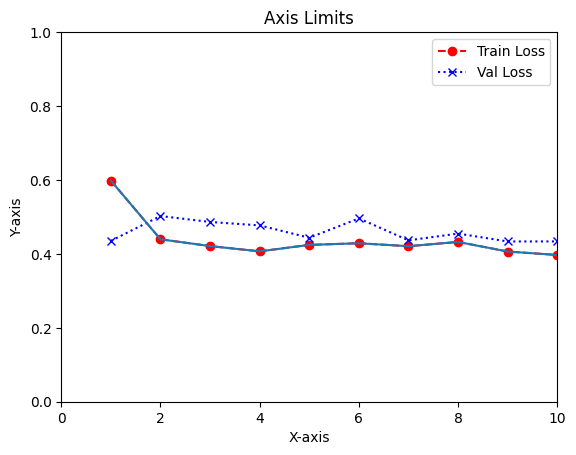

In [ ]:
import matplotlib.pyplot as plt

x, y1, y2 = [], [], []

for i in plot_list:
    x.append(i[0])
    y1.append(i[1])
    y2.append(i[2])

# Customizing line styles and markers
plt.plot(x, y1, label="Train Loss", linestyle='--', marker='o', color='red')
plt.plot(x, y2, label="Val Loss", linestyle=':', marker='x', color='blue')
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Custom Lines")
plt.legend()

# Setting axis limits
plt.plot(x, y1)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Axis Limits")
plt.xlim(0, len(plot_list))  # Set x-axis limits --> depends on the number of epochs --> number of lists in plot_list
plt.ylim(0, 1)  # Set y-axis limits

plt.show()
